In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
from shapely.geometry import Point, LineString
import copy
from math import radians, cos, sin, asin, sqrt, pi
import string

In [3]:
def generate_graph_from_place(
    query, 
    network_type='all_private', 
    simplify=True, retain_all=False, 
    truncate_by_edge=False, 
    which_result=None, 
    buffer_dist=None, 
    clean_periphery=True, 
    custom_filter=None, 
    road_list=None,
):
    """
    Create graph from OSM within the boundaries of some geocodable place(s).

    The query must be geocodable and OSM must have polygon boundaries for the
    geocode result. If OSM does not have a polygon for this place, you can
    instead get its street network using the graph_from_address function,
    which geocodes the place name to a point and gets the network within some
    distance of that point.

    If OSM does have polygon boundaries for this place but you're not finding
    it, try to vary the query string, pass in a structured query dict, or vary
    the which_result argument to use a different geocode result. If you know
    the OSM ID of the place, you can retrieve its boundary polygon using the
    geocode_to_gdf function, then pass it to the graph_from_polygon function.
    Parameters
    ----------
    query : string or dict or list
        the query or queries to geocode to get place boundary polygon(s)
    network_type : string {"all_private", "all", "bike", "drive", "drive_service", "walk"}
        what type of street network to get if custom_filter is None
    simplify : bool
        if True, simplify graph topology with the `simplify_graph` function
    retain_all : bool
        if True, return the entire graph even if it is not connected.
        otherwise, retain only the largest weakly connected component.
    truncate_by_edge : bool
        if True, retain nodes outside boundary polygon if at least one of
        node's neighbors is within the polygon
    which_result : int
        which geocoding result to use. if None, auto-select the first
        (Multi)Polygon or raise an error if OSM doesn't return one.
    buffer_dist : float
        distance to buffer around the place geometry, in meters
    clean_periphery : bool
        if True, buffer 500m to get a graph larger than requested, then
        simplify, then truncate it to requested spatial boundaries
    custom_filter : string
        a custom ways filter to be used instead of the network_type presets
        e.g., '["power"~"line"]' or '["highway"~"motorway|trunk"]'. Also pass
        in a network_type that is in settings.bidirectional_network_types if
        you want graph to be fully bi-directional.
    road_list : string or list
        a filter to only contain certain roads within the graph

    Returns
    -------
    graph : networkx.MultiDiGraph
    """
    #Generate the graph using osmnx using the parameters
    graph = ox.graph_from_place(
        query, 
        network_type=network_type, 
        simplify=simplify, 
        retain_all=retain_all, 
        truncate_by_edge=truncate_by_edge, 
        which_result=which_result, 
        buffer_dist=buffer_dist, 
        clean_periphery=clean_periphery, 
        custom_filter=custom_filter,
    )
    graph = ox.get_undirected(ox.get_digraph(graph))
    #Remove edges that do not have their name in road_list
    if road_list.isinstance(list):
        graph = _isolate_roads(graph, road_list)
    elif road_list.isinstance(string):
        graph = _isolate_road(graph, road_list)
    return graph
def _isolate_road(
    graph, 
    road,
    name_type="name"
):
    """
    Removes all the edges that do not have an edge attribute 'name', or the value
    attributed to the key, 'name', does not contain a string that is in the road_list

    Parameters
    -------
    graph : Networkx.MultiDiGraph
        input graph
    road_list : string
        the road to remain in the graph

    Returns
    -------
    graph : Networkx.MultiDiGraph
    """
    nodeRemover = []
    graph = copy.deepcopy(graph)
    #Removing all the edges in the graph that do not have edges that contain the road name
    for i in graph:
        for j in graph[i]:
            for k in graph[i][j]:
                if graph[i][j][0].get(name_type) == None:
                    nodeRemover.append((i, j))
                    continue
                elif type(graph[i][j][0][name_type]) == list and graph[i][j][0][name_type].count(road) == 0:
                    nodeRemover.append((i, j))
                elif graph[i][j][0][name_type] != road:
                    nodeRemover.append((i, j))
    while(len(nodeRemover)>0) :
        a = nodeRemover.pop()
        if graph[a[0]].get(a[1]) != None:
            graph.remove_edge(a[0], a[1])
    #Removing all isolated vertices of the Graph
    for i in graph:
        if len(graph[i]) == 0:
            nodeRemover.append(i)
    while(len(nodeRemover) > 0):
        x = nodeRemover.pop()
        graph.remove_node(x)
    return graph

def _isolate_roads(
    graph, 
    road_list,
):
    """
    Removes all the edges that do not have an edge attribute 'name', or the value
    attributed to the key, 'name', does not contain a string that is in the road_list

    Parameters
    -------
    graph : Networkx.MultiDiGraph
        input graph
    road_list : list
        the roads to remain in the graph

    Returns
    -------
    graph : Networkx.MultiDiGraph
    """
    remove_list = []
    graph = copy.deepcopy(graph)
    #Removing all the edges in the graph that do not have edges that contain the road name
    for i in graph:
        for j in graph[i]:
            for k in graph[i][j]:
                #Checking if there is a name attribute of the edge
                if graph[i][j][0].get('name') == None:
                    remove_list.append((i, j))
                    continue
                #Going through the road_list and seeing if any match the name of the edge
                keep = False
                for roads in road_list:
                    if type(graph[i][j][0]['name']) == list and graph[i][j][0]['name'].count(roads) >= 0:
                        keep = True
                    elif graph[i][j][0]['name'] == roads:
                        keep = True
                if keep == False:
                    remove_list.append((i, j))
    while(len(remove_list)>0) :
        a = remove_list.pop()
        if graph[a[0]].get(a[1]) != None:
            graph.remove_edge(a[0], a[1])
    #Removing all isolated vertices of the Graph
    for i in graph:
        if len(graph[i]) == 0:
            remove_list.append(i)
    while(len(remove_list) > 0):
        x = remove_list.pop()
        graph.remove_node(x)
    return graph



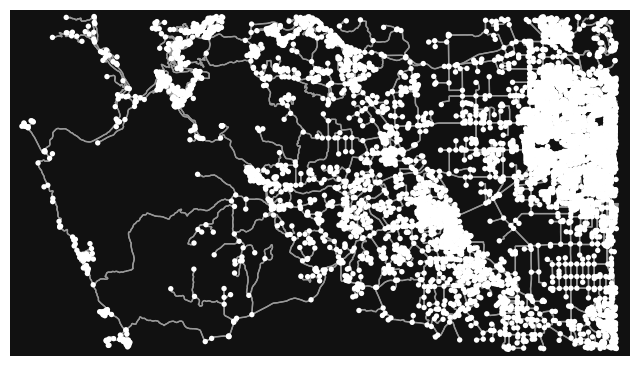

In [9]:
G = ox.graph_from_bbox(38.51, 38.33, -122.71, -123.12, network_type="drive")
fig, ax = ox.plot_graph(G)

In [10]:
roads = set()
for i in G:
    for j in G[i]:
        if G[i][j][0].get('name') and type(G[i][j][0].get('name')) == list:
            for k in G[i][j][0]['name']:
                roads.add(k)
        elif G[i][j][0].get('name') and type(G[i][j][0].get('name')) == str:
            roads.add(G[i][j][0].get('name'))
for i in roads:
    if i == "Pocket Canyon Highway": print(i)

Pocket Canyon Highway


In [13]:
road = "CA 116"
road_list = [road]
my_hw = {i : _isolate_road(G, i, "ref") for i in road_list}
print(my_hw)

{'CA 116': <networkx.classes.multidigraph.MultiDiGraph object at 0x000001C71B5A51D0>}


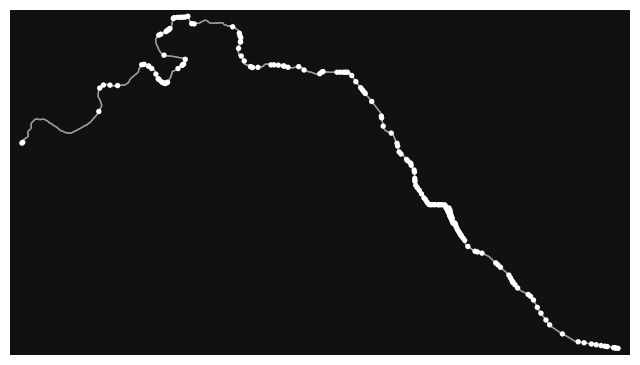

In [14]:
fig, ax = ox.plot_graph(my_hw[road])

In [15]:
for i in my_hw[road]:
    print(my_hw[road][i])

{56069976: {0: {'osmid': 7716654, 'lanes': '2', 'ref': 'CA 116', 'name': 'Healdsburg Avenue', 'highway': 'primary', 'oneway': False, 'reversed': False, 'length': 89.212, 'geometry': <LINESTRING (-122.829 38.405, -122.829 38.405, -122.83 38.405, -122.83 38.405)>}}, 56035773: {0: {'osmid': 7716654, 'lanes': '2', 'ref': 'CA 116', 'name': 'Healdsburg Avenue', 'highway': 'primary', 'oneway': False, 'reversed': True, 'length': 91.09400000000001, 'geometry': <LINESTRING (-122.829 38.405, -122.829 38.405, -122.829 38.405, -122.829 38....>}}}
{56019354: {0: {'osmid': 880960544, 'lanes': '2', 'ref': 'CA 116', 'name': 'Gravenstein Highway South', 'highway': 'primary', 'maxspeed': '50 mph', 'oneway': False, 'reversed': True, 'length': 174.712}}, 11352850418: {0: {'osmid': 880960544, 'lanes': '2', 'ref': 'CA 116', 'name': 'Gravenstein Highway South', 'highway': 'primary', 'maxspeed': '50 mph', 'oneway': False, 'reversed': False, 'length': 118.388, 'geometry': <LINESTRING (-122.782 38.366, -122.782 

In [21]:
def make_road_list(graph):
    """
    Make a graph that only contains 1 road name for road in the system.

    Parameters
    ----------
    graph : Networkx.MultiDiGraph
        input graph

    Returns
    ----------
    dictionary with the key being a road name, and the value is a Netowrkx.Graph
    of all edges with that road name
    """
    roads = set()
    for i in graph:
        for j in graph[i]:
            if graph[i][j][0].get('name') and type(graph[i][j][0].get('name')) == list:
                for k in graph[i][j][0]['name']:
                    roads.add(k)
            elif graph[i][j][0].get('name') and type(graph[i][j][0].get('name')) == str:
                roads.add(graph[i][j][0].get('name'))
    
    return {i:_isolate_road(graph, i) for i in roads}  


road_names = make_road_list(my_hw[road])
road_names_list = list(road_names.keys())
print(road_names_list)


['River Road', 'Front Street', 'CA-116 (River Road)', 'Petaluma Avenue', 'South Main Street', 'Main Street', 'Gravenstein Highway', 'North Main Street', 'McKinley Avenue', 'Gravenstein Highway South', 'Healdsburg Avenue', 'Pocket Canyon Highway', 'Gravenstein Highway North']


In [25]:
from collections import defaultdict
def convert_to_linestrings(
    roads
):
    """
    Creates a Linestring for each of the roads, or a certain list of roads
    in the graph produced from a graph generater method or a graph truncate 
    method.

    Parameters
    ----------
    roads : a dictionary with road name as key, and Networkx.MultiDiGraph as value
    
    Returns
    ----------
    a dictionary containing either all roadnames in road_list or the graph as 
    the key, and the Linestring of the road as the value. 
    """
    roadstrings = defaultdict(list)
    intersections = defaultdict(list)
    for i in roads:
        endpoints = find_end_nodes(roads[i])
        while len(endpoints):
            node = endpoints[0]
            visited = set()
            visited.add(node)
            frontier = [(node, None)]
            path = []
            paths = []
            intersection = []
            while len(frontier):
                node, prev = frontier.pop()
                node_found = False
                if len(path) == 0 and prev:
                    path.append((roads[i].nodes[prev]['y'], roads[i].nodes[prev]['x']))
                if prev and roads[i][prev][node][0].get('geometry'):
                    for j, coords in enumerate(roads[i][prev][node][0]['geometry'].coords):
                        if j > 0:
                            path.append((coords[1], coords[0]))
                else:
                    path.append((roads[i].nodes[node]['y'], roads[i].nodes[node]['x']))
                    intersection.append((roads[i].nodes[node]['y'], roads[i].nodes[node]['x']))
                for j in roads[i][node]:
                    if j not in visited:
                        visited.add(j)
                        frontier.append((j, node))
                        node_found = True
                if node_found == False:
                    paths.append(path[:])
                    path = []
            roadstrings[i].append(paths[:])
            intersections[i].append(intersection[:])
            for j in endpoints:
                if j in visited:
                    endpoints.remove(j)
    return roadstrings, intersections

def find_end_nodes(graph):
    """
    Find all the nodes in an osmnx graph that are endnodes from the _is_endpoint
    function in the osmnx library

    :param Graph: This is the graph where the endpoints to be found are in.
    :return: A list of node ids of the endpoint nodes.
    """
    endNodes = []
    for i in graph:
        if ox.simplification._is_endpoint(graph, i):
            endNodes.append(i)
    return endNodes

def _road_polyline_length(graph, endpoints, edge_list):
    """ 
    Finds how many points are in the LineString that is the road.

    :param Graph: The osmnx graph that is being analyzed and has already 
        had isolateRoad called on it
    :param endpoints: The list of endpoints in Graph founded with the function
        findEndNodes
    :param edge_list: The path between the furthes end points in the graph
    :return: a count of the number of points within the LineString that is the road
    """
    count = 0
    NodeTracker = endpoints[0]
    for i in edge_list:
        if i == endpoints[0]:
            continue
        for j in graph[NodeTracker]:
            if i == j:
                if graph[NodeTracker][j][0].get('geometry') != None:
                    for k in graph[NodeTracker][j][0]['geometry'].coords:
                        if k == (graph.nodes[j]['x'], graph.nodes[j]['y']):
                            break
                        count += 1
                else:
                    count += 1
                NodeTracker = j
    return count


defaultdict(<class 'list'>, {'River Road': [[[(38.5024984, -122.9953316), (38.5023815, -122.9956814), (38.5022792, -122.9960413), (38.5021935, -122.9964109), (38.5021353, -122.9967669), (38.5021196, -122.9968627), (38.5021085, -122.9969305), (38.5020792, -122.9971771), (38.5020229, -122.9977269), (38.5020082, -122.9984888), (38.5020041, -122.9987026), (38.502003, -122.9987856), (38.5019981, -122.9992598), (38.5019951, -122.9994987), (38.5019913, -122.9996952), (38.5019826, -123.0002222), (38.5019814, -123.0003094)]], [[(38.4670211, -123.050926), (38.4668867, -123.0513208), (38.4667859, -123.0515526), (38.4666784, -123.0517843), (38.4665642, -123.0520161), (38.466423, -123.052265), (38.4662617, -123.0525053), (38.4661005, -123.0527199), (38.4659593, -123.0528915), (38.4657846, -123.0530804), (38.4656166, -123.0532349), (38.4654542, -123.0533815), (38.4654284, -123.0534065), (38.4652738, -123.0535267), (38.4651193, -123.0536383), (38.4649781, -123.0537327), (38.4648303, -123.0538185), (3

In [31]:
# Here we convert a graph structure to polylines, because the graph itself is too messy to deal with.
# Function convert_to_linestrings() returns both polylines and intersections.
polylines, xections = convert_to_linestrings(road_names)
print(polylines)
print(xections)

defaultdict(<class 'list'>, {'River Road': [[[(38.5024984, -122.9953316), (38.5023815, -122.9956814), (38.5022792, -122.9960413), (38.5021935, -122.9964109), (38.5021353, -122.9967669), (38.5021196, -122.9968627), (38.5021085, -122.9969305), (38.5020792, -122.9971771), (38.5020229, -122.9977269), (38.5020082, -122.9984888), (38.5020041, -122.9987026), (38.502003, -122.9987856), (38.5019981, -122.9992598), (38.5019951, -122.9994987), (38.5019913, -122.9996952), (38.5019826, -123.0002222), (38.5019814, -123.0003094)]], [[(38.4670211, -123.050926), (38.4668867, -123.0513208), (38.4667859, -123.0515526), (38.4666784, -123.0517843), (38.4665642, -123.0520161), (38.466423, -123.052265), (38.4662617, -123.0525053), (38.4661005, -123.0527199), (38.4659593, -123.0528915), (38.4657846, -123.0530804), (38.4656166, -123.0532349), (38.4654542, -123.0533815), (38.4654284, -123.0534065), (38.4652738, -123.0535267), (38.4651193, -123.0536383), (38.4649781, -123.0537327), (38.4648303, -123.0538185), (3

In [32]:
def interpolate_roads(
    roads,
    distance=1000,
):
    """
    Find equidistant points along the a linestring using distance
    calculations that assume that these are coordinates on Earth.

    Parameters
    -------
    roads : dictionary with the road name as the key, and value is a list of list of coordinates that make up the sections of road
    distance : distance between each point in meters

    Returns
    --------
    a dictionary with the road name as key and a list of list of points that is the road segments
    """
    interpolated = defaultdict(list)
    index = 0
    distance_temp = 0
    for i in roads:
        for j in roads[i]:
            if len(j) == 0:
                continue
            node = j[0]
            path = []
            index = 0
            while index < len(j)-1:
                distance_next_point = ox.distance.great_circle_vec(node[0], node[1], j[index+1][0], j[index+1][1])
                if distance_next_point < distance_temp:
                    distance_temp -= distance_next_point
                    index += 1
                    node = j[index]
                else:
                    bearing = ox.bearing.calculate_bearing(node[0], node[1], j[index+1][0], j[index+1][1])
                    coord = intermediate_point(node[0], node[1], bearing, distance_temp)
                    path.append((coord, bearing))
                    node = coord
                    distance_temp = distance
            if len(path):
                interpolated[i].append(path)
    return interpolated

def intermediate_point(lat, lon, bearing, distance, radius=6371009):
    angular_distance = distance / radius
    delta_lat = angular_distance * cos(bearing * pi / 180) * 180 / pi
    delta_lon = angular_distance * sin(bearing * pi / 180) / cos(lat * pi / 180) * 180 / pi
    return lat + delta_lat, lon + delta_lon



In [33]:
inter = interpolate_roads(polylines, distance=500)
print(inter)
for i in inter:
    print(i, inter[i])